In [1]:
# GK Hyperparameter Optimization
#%%
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_roc_curve
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import pandas as pd

In [2]:
## Import Data
df = pd.read_csv("PlayerProductivity.csv", encoding ="Utf-8")

# Deleting Redundant columns based on Domian Specific Knowledge
productivity_df = df.drop(['Date','Sub Position','Match id','Player Forename',
                                        'Player ID','Player Surname','Team Formation','CompId','Team Formation',
                                        'Team','Team Id','Opposition','Venue','Appearances','CompId',
                                          'Substitute On','Substitute Off','SeasId','Opposition id',
                                        'Time Played','Starts','First Goal','Goals'], 1)


# adjust and create new columns 
position_gk = productivity_df[productivity_df['Position Id'] == 1] # 1 = GK  
position_gk = position_gk.loc[:, (position_gk != position_gk.iloc[0]).any()] # Dropping constant columns
position_gk = position_gk[position_gk.columns[position_gk.sum()>100]] # Dropping Sparse columns, colums with totalvalues <100

# select key features
features = ['Champions League Performer','% successful passes forwards', 'Aerial Duels lost', 'Big Chances Faced', 'Challenge Lost', 'Clean Sheets', 'Corners Conceded', 'Crosses not Claimed', 'Defensive Aerial Duels Lost', 'Defensive Aerial Duels Won', 'Defensive Ground Duels Lost', 'Defensive Ground Duels Won', 'Duels lost', 
            'Error leading to Attempt', 'GK - Pick up', 'GK Distribution', 'GK Long Accuracy', 'GK Long Distribution', 'GK Short Accuracy', 'GK Short Distribution', 'GK Successful Distribution', 'GK Unsuccessful Distribution', 'Goals Conceded', 'Goals Conceded Inside Box', 'Ground Duels lost', 
            'Ground Duels won', 'Interceptions', 'Keeper Sweeper Unsuccessful', 'Key Set Pieces', 'Pass Forward', 'Pass Left', 'Pass Right', 'Passes Received', 'Penalties Conceded', 'Punches', 'Recoveries', 'Saves Body', 'Saves Caught', 'Saves Collected', 'Saves Feet', 'Saves Hands', 'Saves Made', 
            'Saves Made from Inside Box', 'Saves Parried Safe', 'Saves Stooping', 'Saves from Penalty', 'Shots On Conceded', 'Shots On Conceded Inside Box', 'Successful Ball Touch', 'Successful Dribbles', 'Successful Long Balls', 'Successful Long Passes', 'Successful Passes Defensive third', 
            'Successful Passes Final third', 'Successful Passes Middle third', 'Successful Passes Opposition Half', 'Successful Passes Own Half', 'Successful Short Passes', 'Total Blocked Shots Conceded', 'Total Fouls Conceded', 'Total Shots Conceded', 'Total Successful Passes All', 
            'Total Successful Passes Excl Crosses Corners', 'Total Unsuccessful Passes All', 'Total Unsuccessful Passes Excl Crosses Corners', 'Touches', 'Unsuccessful Ball Touch', 'Unsuccessful Long Balls', 'Unsuccessful Long Passes', 'Unsuccessful Passes Defensive third', 'Unsuccessful Passes Final third', 
            'Unsuccessful Passes Middle third', 'Unsuccessful Passes Opposition Half', 'Unsuccessful Short Passes']

position_gk = position_gk[features]

## Standerdize the position_gk

normalized_df = (position_gk - position_gk.min())/(position_gk.max() - position_gk.min())
normalized_df['Champions League Performer'] = normalized_df['Champions League Performer'].astype(int) # binary conversion

# reset dataset name
position_gk = normalized_df

# Test Train Split
X = position_gk.drop(['Champions League Performer'], axis = 1)
y = position_gk['Champions League Performer']


# Random undersampling to help with the class inbalance 
rus = RandomUnderSampler(random_state=0, replacement=False)
X_resampled, y_resampled = rus.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.20, stratify=y_resampled, random_state=1)

# Training dataframe

training_df = pd.concat([X_train, y_train], axis=1)

C:\Users\YK0614\AppData\Local\Temp/ipykernel_22348/2651421893.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  productivity_df = df.drop(['Date','Sub Position','Match id','Player Forename',


In [3]:
position_gk = productivity_df[productivity_df['Position Id'] == 1] # 1 = GK
position_gk['Player ID'].nunique()

KeyError: 'Player ID'

In [ ]:
training_df

In [ ]:
X_resampled

In [6]:
X_resampled['Player ID'].nunique()

300

## Logistic Regression

In [4]:
# define the data model

# define grid serach inputs
# scoring metric: accuracy
# Use 5 fold CV

# Random Forrest Hyperparameters:
# Number of trees: start with 10 times the number of features
# Used max_features hyperparameter to control the split-variable randomization
# Used node size hyperparameter to control tree complexity: 'max_leaf_nodes'

# Number of features
nof = len(position_gk.columns)

params = {
    'C': 1.623776739188721,
    'class_weight': None,
    'dual': False,
    'fit_intercept': True,
    'intercept_scaling': 1,
    'l1_ratio': None,
    'max_iter': 10000,
    'multi_class': 'auto',
    'n_jobs': None,
    'penalty': 'l2',
    'random_state': 42,
    'solver': 'liblinear',
    'tol': 0.0001,
    'verbose': 0,
    'warm_start': False
}

####### Log Reg

# Define grid, CV is default to 5 fold Stratified
logreg = LogisticRegression(**params)

logreg.fit(X_train, y_train)

LogisticRegression(C=1.623776739188721, max_iter=10000, random_state=42,
                   solver='liblinear')

[[1674  693]
 [ 677 1690]]


Text(0.5, 1.0, 'Logistic Regression Training Data')

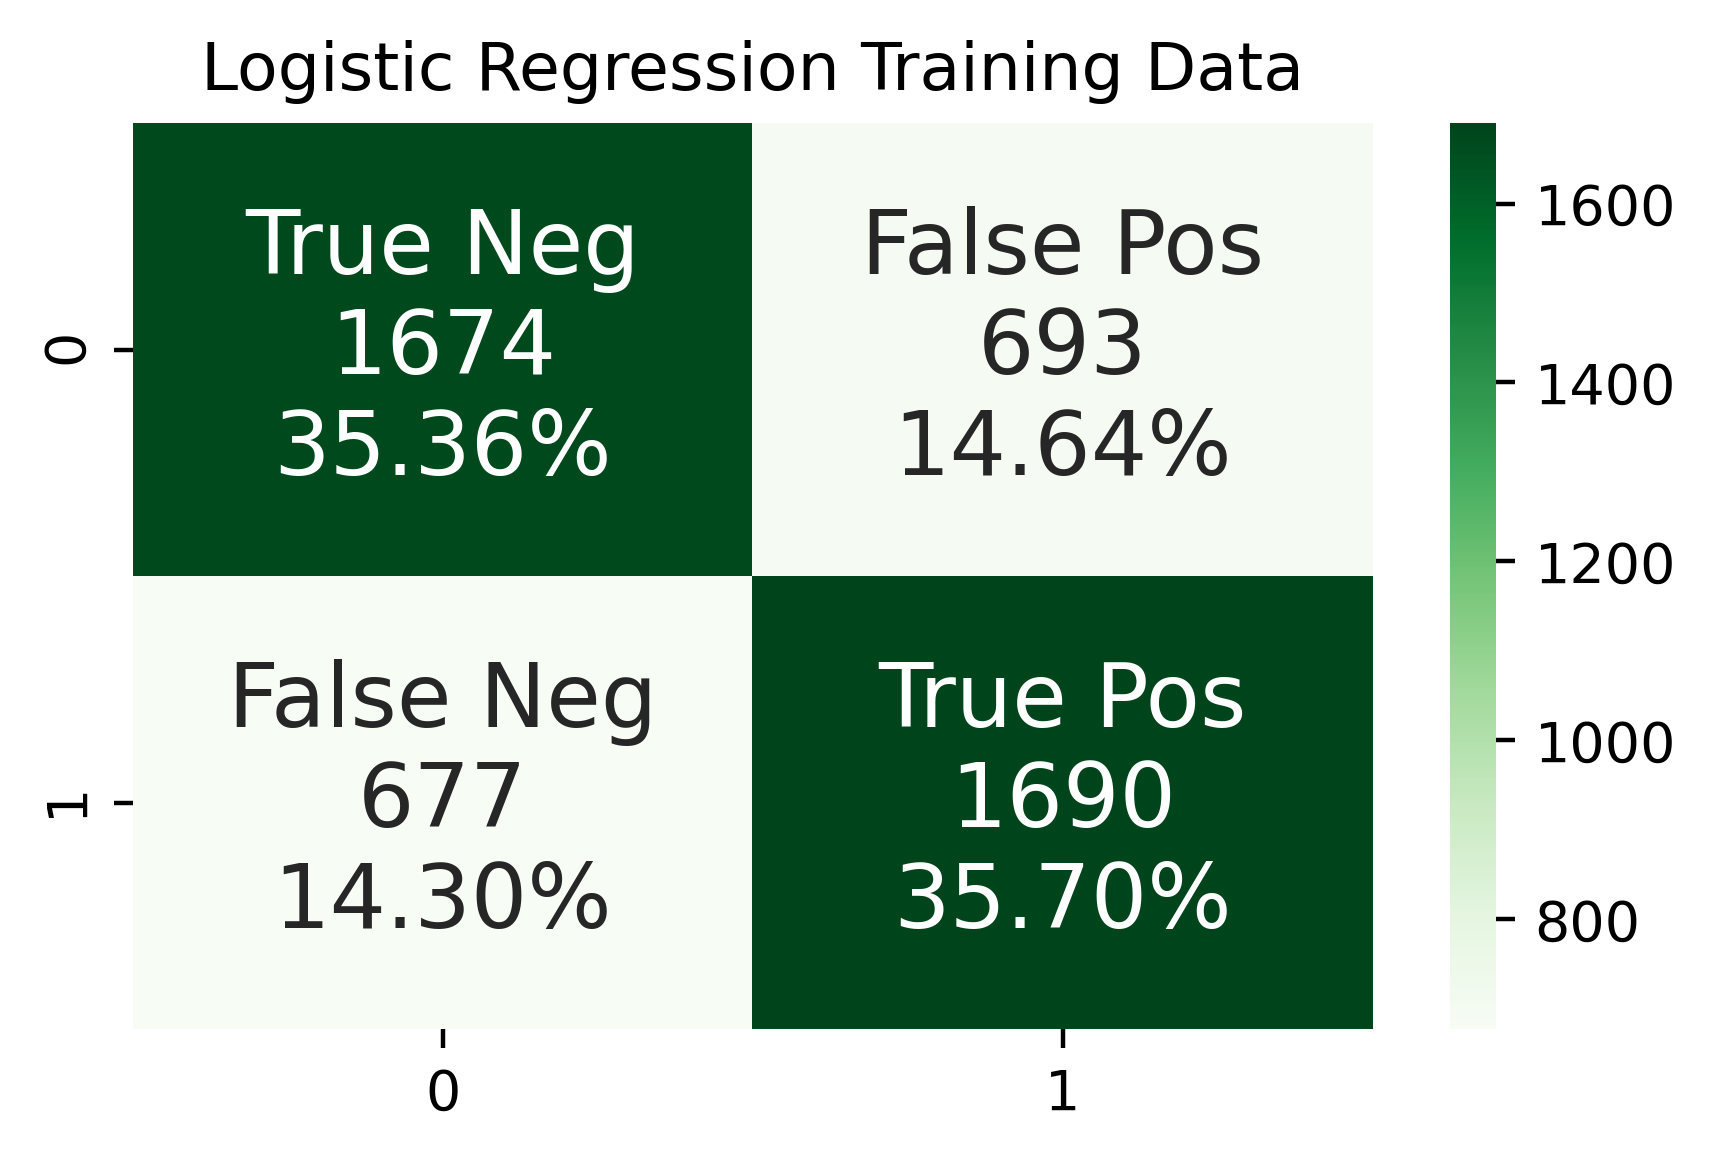

In [5]:
# Confusion Matrix
# Training set

#Generate predictions with the model using our X values
y_pred = logreg.predict(X_train)

#Get the confusion matrix
cf_matrix = confusion_matrix(y_train, y_pred)

print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(5,3), dpi = 400)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greens', annot_kws={"fontsize":16}, ax=ax)

plt.title('Logistic Regression Training Data')

[[396 196]
 [195 397]]


Text(0.5, 1.0, 'Logistic Regression Testing Data')

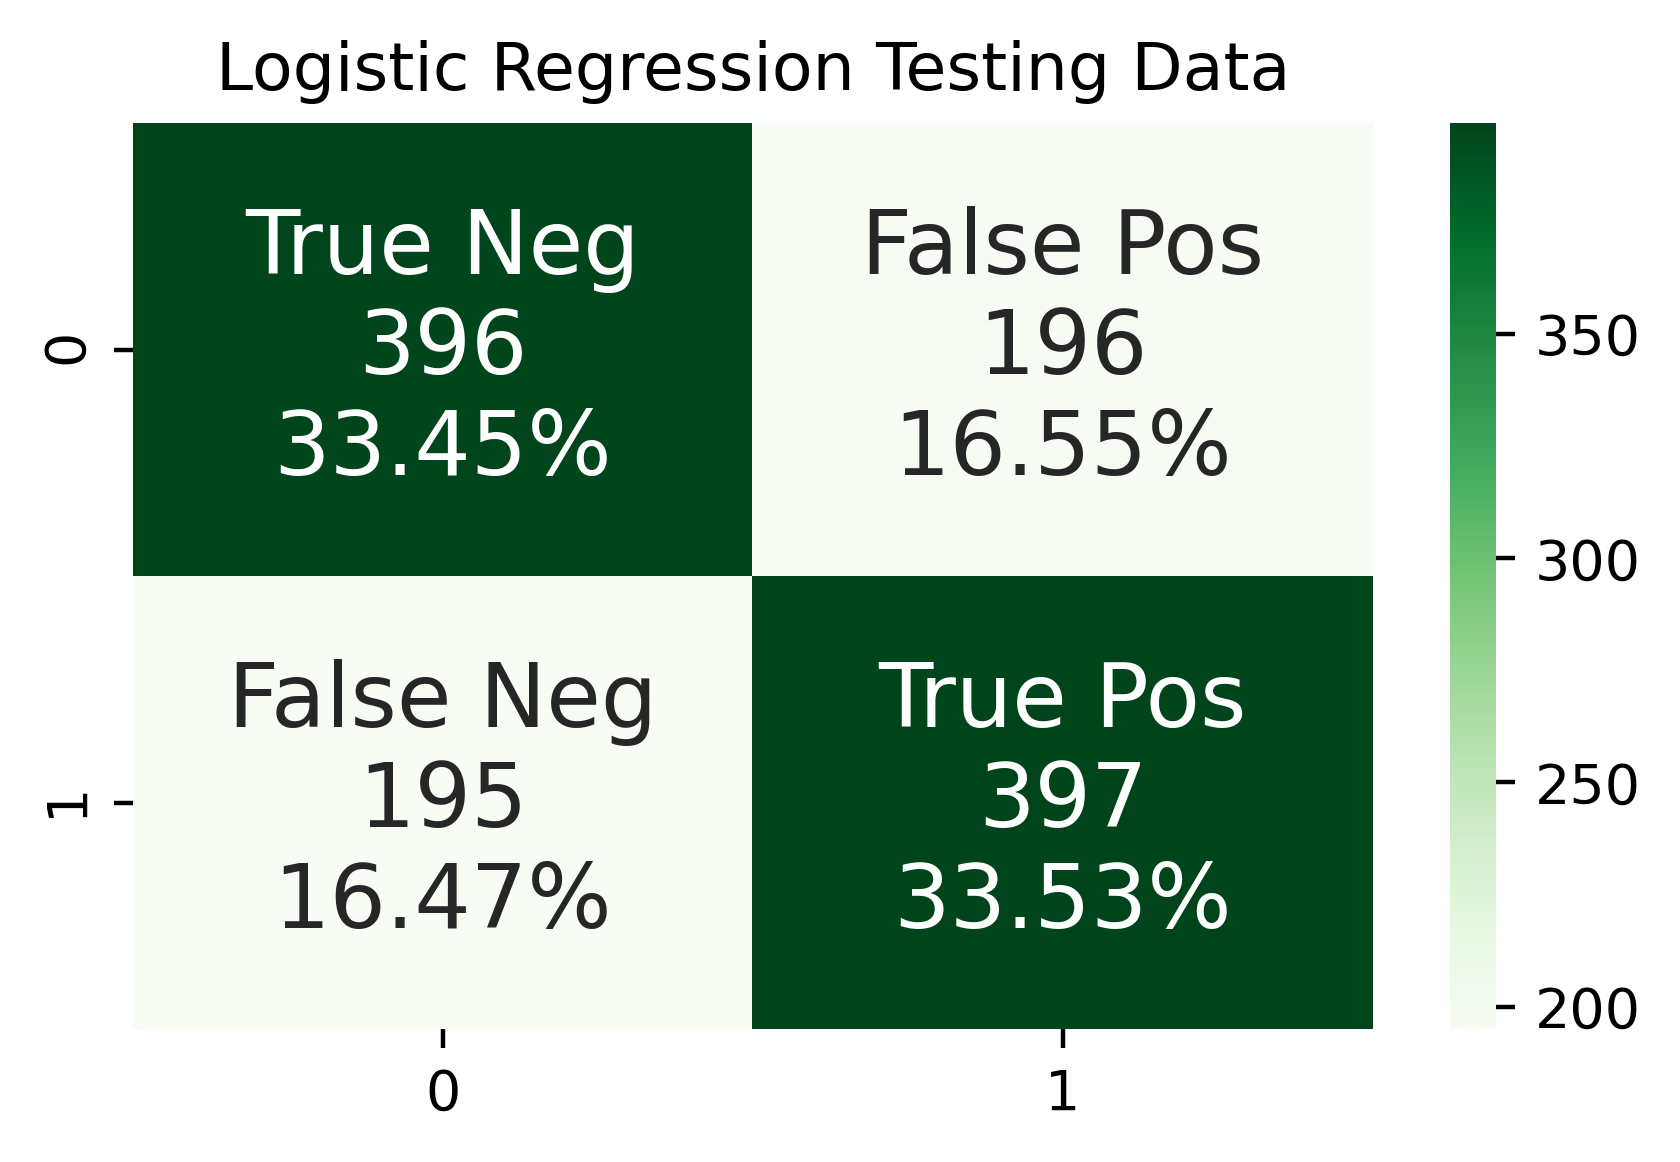

In [6]:
# Testing set

#Generate predictions with the model using our X values
y_pred = logreg.predict(X_test)

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(5,3), dpi = 400)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greens', annot_kws={"fontsize":16}, ax=ax)

plt.title('Logistic Regression Testing Data')

In [40]:
# Classification report train


# Test the final model on the hold out test_set
# assign true & predict vectors to vairables 
y_true, y_pred = y_train, logreg.predict(X_train)

# Build a text report showing the main classification metrics
target_names = ['Non CL Player', 'CL Player']
train_set_results = classification_report(y_true, y_pred, target_names=target_names)

print(train_set_results)

               precision    recall  f1-score   support

Non CL Player       0.71      0.71      0.71      2367
    CL Player       0.71      0.71      0.71      2367

     accuracy                           0.71      4734
    macro avg       0.71      0.71      0.71      4734
 weighted avg       0.71      0.71      0.71      4734



In [41]:
# Test the final model on the hold out test_set
# assign true & predict vectors to vairables 
y_true, y_pred = y_test, logreg.predict(X_test)

# Build a text report showing the main classification metrics
target_names = ['Non CL Player', 'CL Player']
test_set_results = classification_report(y_true, y_pred, target_names=target_names)

print(test_set_results)

               precision    recall  f1-score   support

Non CL Player       0.67      0.67      0.67       592
    CL Player       0.67      0.67      0.67       592

     accuracy                           0.67      1184
    macro avg       0.67      0.67      0.67      1184
 weighted avg       0.67      0.67      0.67      1184



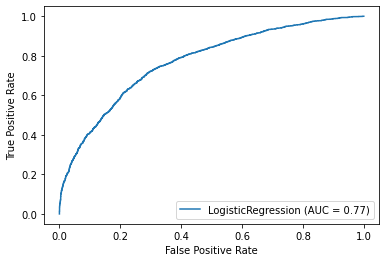

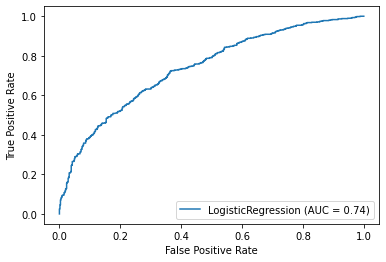

In [42]:
# ROC

plot_roc_curve(logreg, X_train, y_train)
plot_roc_curve(logreg, X_test, y_test)

In [5]:
# Cross Validation LR

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold, KFold

X = X_resampled
y = y_resampled 

clf = logreg

scoring = ['f1','roc_auc','accuracy','balanced_accuracy',]

scores =  cross_validate(clf, X, y, cv=StratifiedKFold(5),return_train_score = True,scoring=scoring)
cv = pd.DataFrame(scores)
cv.describe()

,fit_time,score_time,test_f1,train_f1,test_roc_auc,train_roc_auc,test_accuracy,train_accuracy,test_balanced_accuracy,train_balanced_accuracy
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.043685,0.014335,0.664586,0.706541,0.729365,0.770336,0.671004,0.704081,0.671003,0.704080
std,0.009314,0.019273,0.055089,0.012435,0.057700,0.014095,0.044518,0.014604,0.044510,0.014604
min,0.035906,0.004987,0.595668,0.691813,0.662353,0.753129,0.621622,0.685889,0.621622,0.685889
25%,0.039895,0.005653,0.624357,0.695779,0.686065,0.759436,0.629755,0.692503,0.629767,0.692500
50%,0.040891,0.005984,0.667817,0.708840,0.723949,0.771920,0.674831,0.706379,0.674831,0.706379
75%,0.041888,0.006250,0.708839,0.715736,0.776604,0.780017,0.712838,0.716156,0.712838,0.716156
max,0.059842,0.048801,0.726248,0.720539,0.797854,0.787176,0.715976,0.719476,0.715956,0.719476


In [131]:
# Feature Imp

df_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Rank Score': logreg.coef_.flatten(),
    'Coef': logreg.coef_[0],
}).sort_values(by='Rank Score', ascending=False).reset_index(drop=True)

In [132]:
logreg_features = df_feature_importance.sort_values(by='Rank Score', ascending=False)
logreg_features


,Feature,Rank Score,Coef
0,Passes Received,2.743619,2.743619
1,% successful passes forwards,1.144914,1.144914
2,Unsuccessful Passes Middle third,1.051956,1.051956
3,GK Short Distribution,0.882657,0.882657
4,Successful Passes Defensive third,0.840918,0.840918
...,...,...,...
68,Total Unsuccessful Passes Excl Crosses Corners,-1.325748,-1.325748
69,GK - Pick up,-1.330936,-1.330936
70,Shots On Conceded,-1.514591,-1.514591
71,Total Successful Passes Excl Crosses Corners,-2.059302,-2.059302


In [45]:
# Recursive Feature extraction

from sklearn.feature_selection import RFECV



# classifications using Logistic regression accuracy scoring
rfecv_logreg= RFECV(estimator=logreg,
                  step=1,
                  cv=StratifiedKFold(5),  # 5-fold CV
                  min_features_to_select = 20,
                  scoring='f1')
# Fit model 
rfecv_logreg.fit(X_resampled, y_resampled)

print("Total number of features : %d" % len(X_resampled.columns))
print("Optimal number of features : %d" % rfecv_logreg.n_features_)

Total number of features : 73
Optimal number of features : 46


In [133]:

# Extraxting the core features with coefficients

n_feat_logreg = X_train.columns[rfecv_logreg.support_]
df_coef_logreg = pd.DataFrame({
            'Features_logreg' : n_feat_logreg,
            'Coef' : rfecv_logreg.estimator_.coef_[0]}).sort_values(by='Coef', ascending = False).reset_index(drop = True)
df_coef_logreg

,Features_logreg,Coef
0,Passes Received,3.386554
1,Unsuccessful Passes Middle third,1.468923
2,% successful passes forwards,1.158227
3,Saves Hands,0.911631
4,GK Short Distribution,0.809298
5,Penalties Conceded,0.791921
6,Pass Forward,0.785630
7,Saves Caught,0.626700
8,Error leading to Attempt,0.527048
9,GK Short Accuracy,0.522190


## Random Forest

In [9]:
# Model Params

from sklearn.ensemble import RandomForestClassifier

# define grid serach inputs
# scoring metric: accuracy
# Use 5 fold CV

# Random Forrest Hyperparameters:
# Number of trees: start with 10 times the number of features
# Used max_features hyperparameter to control the split-variable randomization
# Used node size hyperparameter to control tree complexity: 'max_leaf_nodes'

# Number of features
nof = len(position_gk.columns)

params = {
    'bootstrap': True,
    'ccp_alpha': 0.0,
    'class_weight': 'balanced',
    'criterion': 'gini',
    'max_depth': 10,
    'max_features': 0.5,
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 10,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'n_estimators': 1110,
    'n_jobs': None,
    'oob_score': False,
    'random_state': 42,
    'verbose': 0,
    'warm_start': False
}

# Define grid, CV is default to 5 fold Stratified
rfc = RandomForestClassifier(**params)

rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.5,
                       min_samples_leaf=10, n_estimators=1110, random_state=42)

[[1992  375]
 [ 448 1919]]


Text(0.5, 1.0, 'Random Forest Training Data')

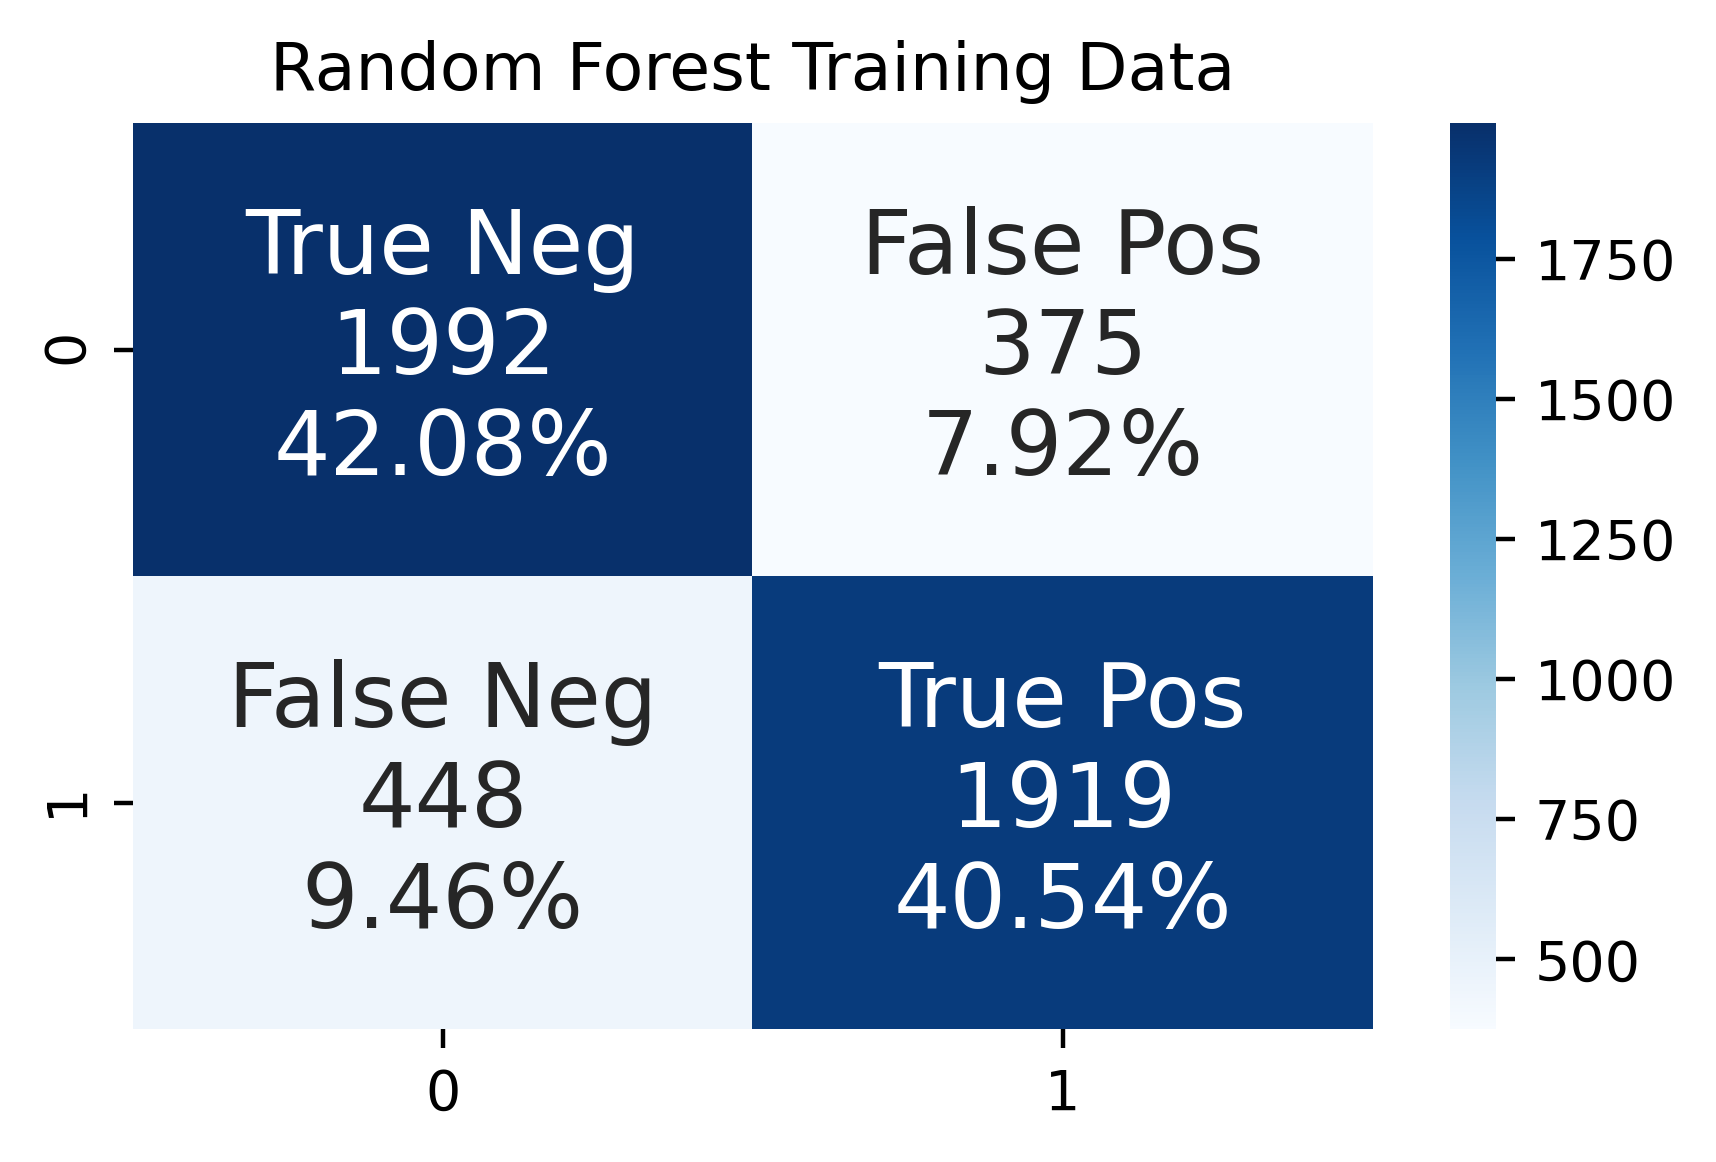

In [8]:
# Confusion matrix plot 
# Training set

#Generate predictions with the model using our X values
y_pred = rfc.predict(X_train)

#Get the confusion matrix
cf_matrix = confusion_matrix(y_train, y_pred)

print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(5,3), dpi = 400)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":16}, ax=ax)

plt.title('Random Forest Training Data')

[[424 168]
 [213 379]]


Text(0.5, 1.0, 'Random Forest Testing Data')

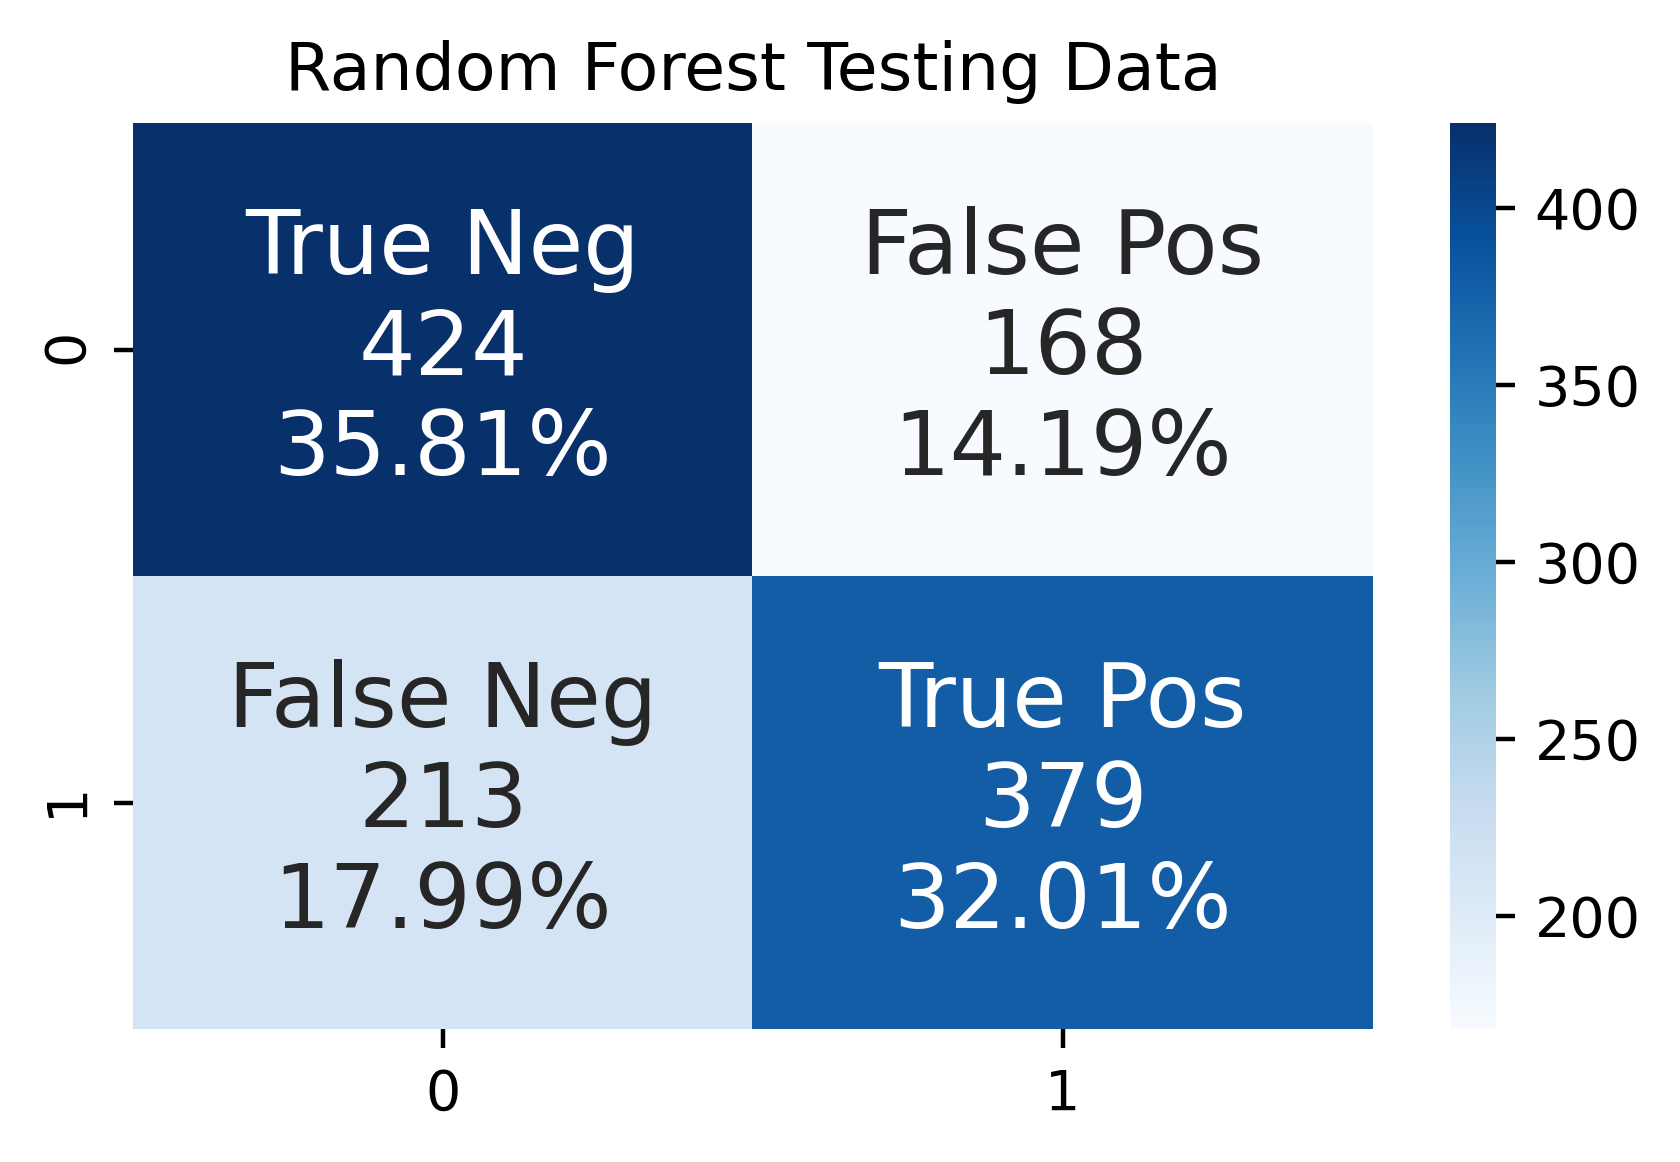

In [9]:
# Confusion matrix plot 
# Training set

#Generate predictions with the model using our X values
y_pred = rfc.predict(X_test)

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(5,3), dpi = 400)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":16}, ax=ax)

plt.title('Random Forest Testing Data')

In [28]:
# Classification report train

# Test the final model on the hold out test_set
# assign true & predict vectors to vairables 
y_true, y_pred = y_train, rfc.predict(X_train)

# Build a text report showing the main classification metrics
target_names = ['Non CL Player', 'CL Player']
train_set_results = classification_report(y_true, y_pred, target_names=target_names)
print(train_set_results)

               precision    recall  f1-score   support

Non CL Player       0.82      0.84      0.83      2367
    CL Player       0.84      0.81      0.82      2367

     accuracy                           0.83      4734
    macro avg       0.83      0.83      0.83      4734
 weighted avg       0.83      0.83      0.83      4734



In [82]:

# Test the final model on the hold out test_set
# assign true & predict vectors to vairables 

y_true, y_pred = y_test, rfc.predict(X_test)

# Build a text report showing the main classification metrics
target_names = ['Non CL Player', 'CL Player']
test_set_results = classification_report(y_true, y_pred, target_names=target_names)
print(test_set_results)

               precision    recall  f1-score   support

Non CL Player       0.67      0.72      0.69       592
    CL Player       0.69      0.64      0.67       592

     accuracy                           0.68      1184
    macro avg       0.68      0.68      0.68      1184
 weighted avg       0.68      0.68      0.68      1184



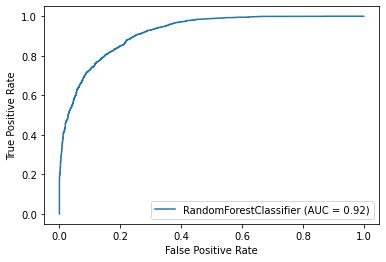

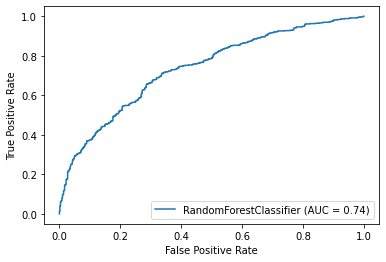

In [30]:
# ROC curves

plot_roc_curve(rfc, X_train, y_train)
plot_roc_curve(rfc, X_test, y_test)

In [11]:
# Cross Validation RF

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold, KFold

X = X_resampled
y = y_resampled 

clf = rfc
scoring = ['f1','roc_auc','accuracy','balanced_accuracy']

scores =  cross_validate(clf, X, y, cv=StratifiedKFold(5),return_train_score = True,scoring=scoring)
cv = pd.DataFrame(scores)
cv.describe()

,fit_time,score_time,test_f1,train_f1,test_roc_auc,train_roc_auc,test_accuracy,train_accuracy,test_balanced_accuracy,train_balanced_accuracy
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,22.743559,0.541863,0.649708,0.823559,0.723290,0.917123,0.669309,0.826842,0.669308,0.826841
std,3.520799,0.035625,0.063046,0.005683,0.051191,0.003282,0.045141,0.004584,0.045124,0.004586
min,18.444944,0.509640,0.573333,0.816699,0.655246,0.913168,0.621622,0.821964,0.621622,0.821958
25%,21.673131,0.528587,0.603232,0.818456,0.693902,0.914548,0.626374,0.822138,0.626423,0.822138
50%,21.933220,0.533575,0.661844,0.826255,0.727570,0.917239,0.683855,0.828897,0.683800,0.828897
75%,23.573697,0.534500,0.676522,0.826478,0.752098,0.919989,0.685811,0.828933,0.685811,0.828936
max,28.092804,0.603012,0.733610,0.829906,0.787636,0.920671,0.728885,0.832277,0.728885,0.832277


In [31]:
# Feature importances


df_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Rank Score': rfc.feature_importances_
}).sort_values(by='Rank Score', ascending=False).reset_index(drop=True)

In [32]:

df_feature_importance.sort_values(by='Rank Score', ascending=False)[:20]

,Feature,Rank Score
0,Unsuccessful Long Passes,0.077108
1,Total Unsuccessful Passes All,0.072537
2,Successful Long Balls,0.069211
3,Successful Passes Opposition Half,0.059888
4,Unsuccessful Passes Opposition Half,0.041684
5,Unsuccessful Passes Final third,0.032758
6,Total Unsuccessful Passes Excl Crosses Corners,0.031276
7,Successful Long Passes,0.025135
8,Goals Conceded,0.024806
9,Successful Short Passes,0.024543


In [93]:
# Recrussive feature Extraction RF

from sklearn.feature_selection import RFECV


# classifications using Logistic regression accuracy scoring
rfecv_rfc = RFECV(estimator=rfc,
                  step=1,
                  cv=StratifiedKFold(5),  # 5-fold CV
                  min_features_to_select = 20,
                  scoring='f1')

# Fit model 
rfecv_rfc.fit(X_resampled, y_resampled)

print("Total number of features : %d" % len(X_resampled.columns))
print("Optimal number of features : %d" % rfecv_rfc.n_features_)

Total number of features : 73
Optimal number of features : 25


In [103]:
# Extraxting the core features with coefficients

# features
n_feat_rfc = X.columns[rfecv_rfc.support_]

df_coef_rfc = pd.DataFrame({
    'Features_rfc': n_feat_rfc,
    'Coef': rfecv_rfc.estimator_.feature_importances_
    }).sort_values(by='Coef', ascending=False).reset_index(drop=True)

df_coef_rfc

,Features_rfc,Coef
0,Total Unsuccessful Passes All,0.098494
1,Unsuccessful Long Passes,0.088735
2,Successful Passes Opposition Half,0.066870
3,Successful Long Balls,0.062727
4,Unsuccessful Passes Opposition Half,0.049880
5,Total Unsuccessful Passes Excl Crosses Corners,0.045686
6,Goals Conceded,0.043067
7,Passes Received,0.038909
8,Successful Short Passes,0.034280
9,% successful passes forwards,0.034114


## Gradient Boosting Machine

In [15]:
from sklearn.ensemble import GradientBoostingClassifier 

# Model params

# define the data model

# define grid serach inputs
# scoring metric: accuracy
# Use 5 fold CV

# Random Forrest Hyperparameters:
# Number of trees: start with 10 times the number of features
# Used max_features hyperparameter to control the split-variable randomization
# Used node size hyperparameter to control tree complexity: 'max_leaf_nodes'

# Number of features
nof = len(position_gk.columns)

params = {
    'ccp_alpha': 0.0,
    'criterion': 'friedman_mse',
    'init': None,
    'learning_rate': 0.025,
    'loss': 'deviance',
    'max_depth': 5,
    'max_features': 0.25,
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 100,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'n_estimators': 500,
    'n_iter_no_change': None,
    'random_state': 42,
    'subsample': 0.15,
    'tol': 0.0001,
    'validation_fraction': 0.1,
    'verbose': 0,
    'warm_start': False
}

######### Gradient boost

# Define grid, CV is default to 5 fold Stratified
GBC = GradientBoostingClassifier(**params)

GBC.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.025, max_depth=5, max_features=0.25,
                           min_samples_leaf=100, n_estimators=500,
                           random_state=42, subsample=0.15)

[[1755  612]
 [ 714 1653]]


Text(0.5, 1.0, 'Gradient Boosting Classifier Training Data')

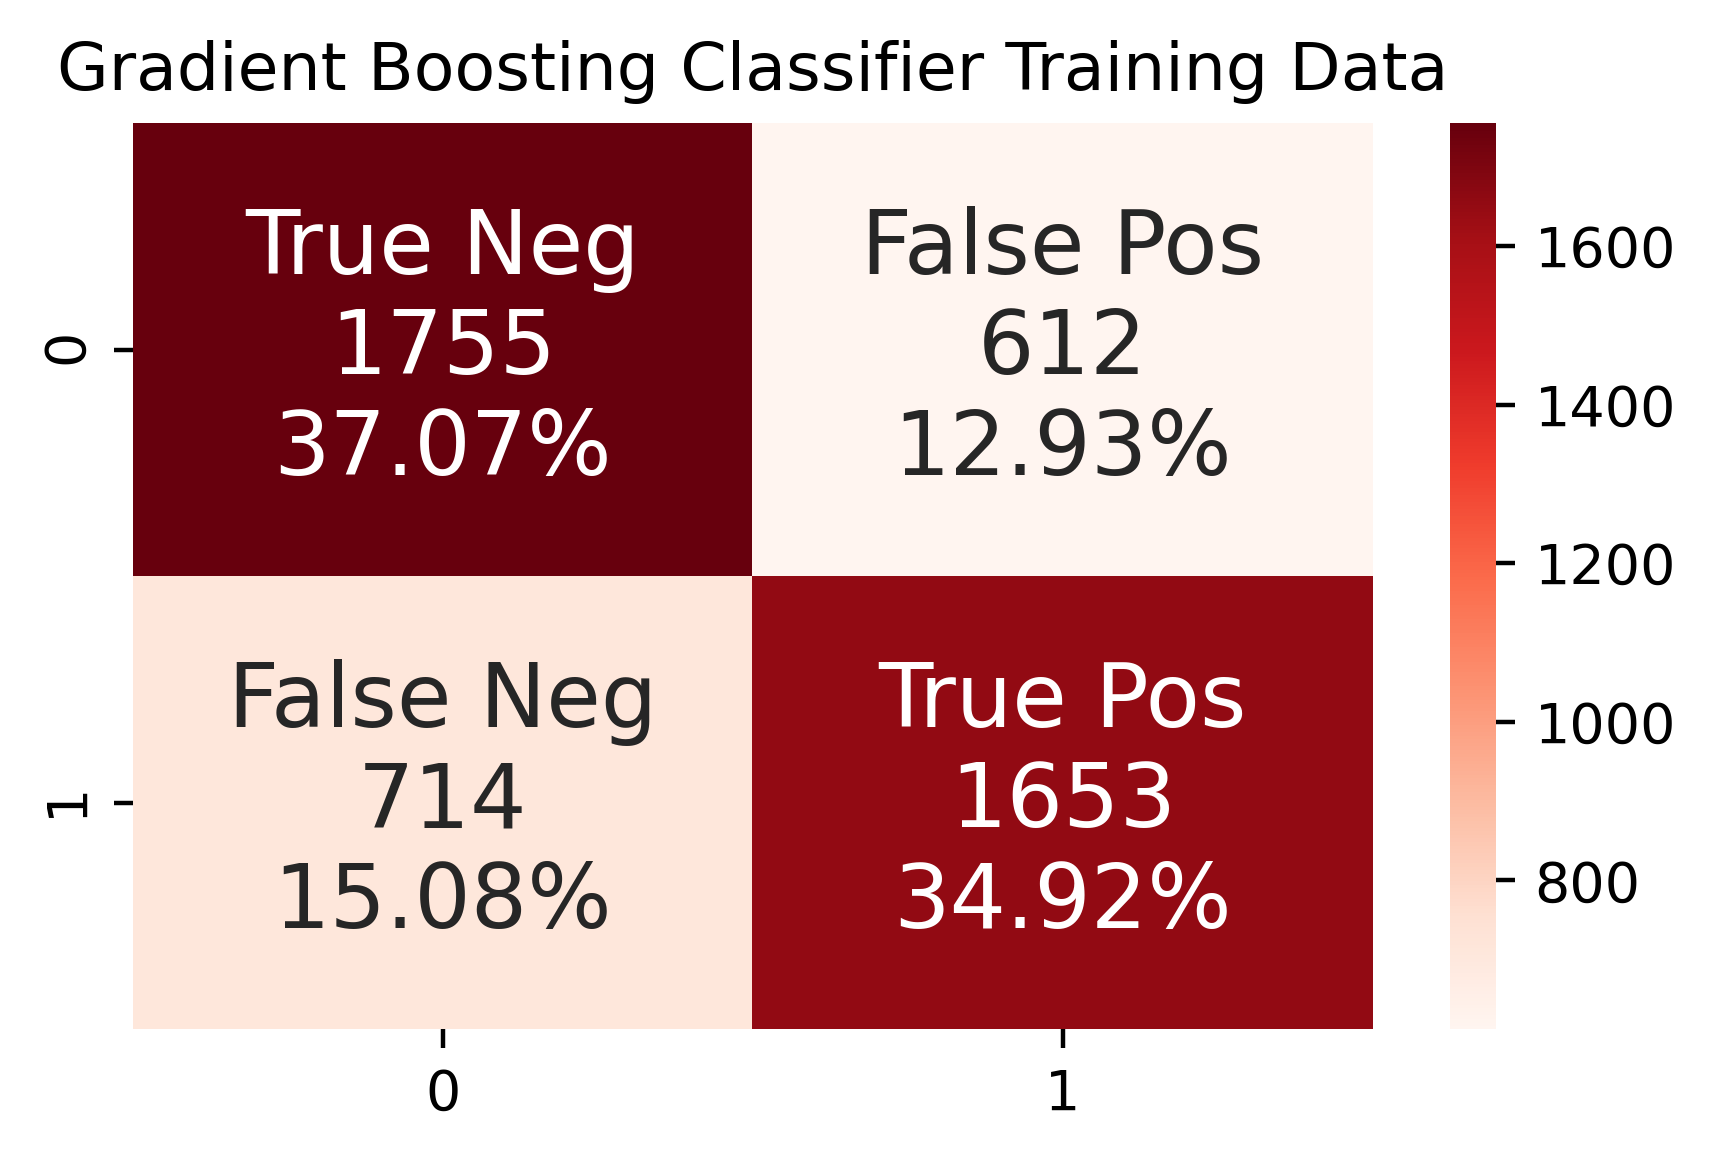

In [11]:
# Confusion matrix plot 
# Training set

#Generate predictions with the model using our X values
y_pred = GBC.predict(X_train)

#Get the confusion matrix
cf_matrix = confusion_matrix(y_train, y_pred)

print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(5,3),dpi = 400)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Reds', annot_kws={"fontsize":16}, ax=ax)

plt.title('Gradient Boosting Classifier Training Data')

[[428 164]
 [216 376]]


Text(0.5, 1.0, 'Gradient Boosting Classifier Testing Data')

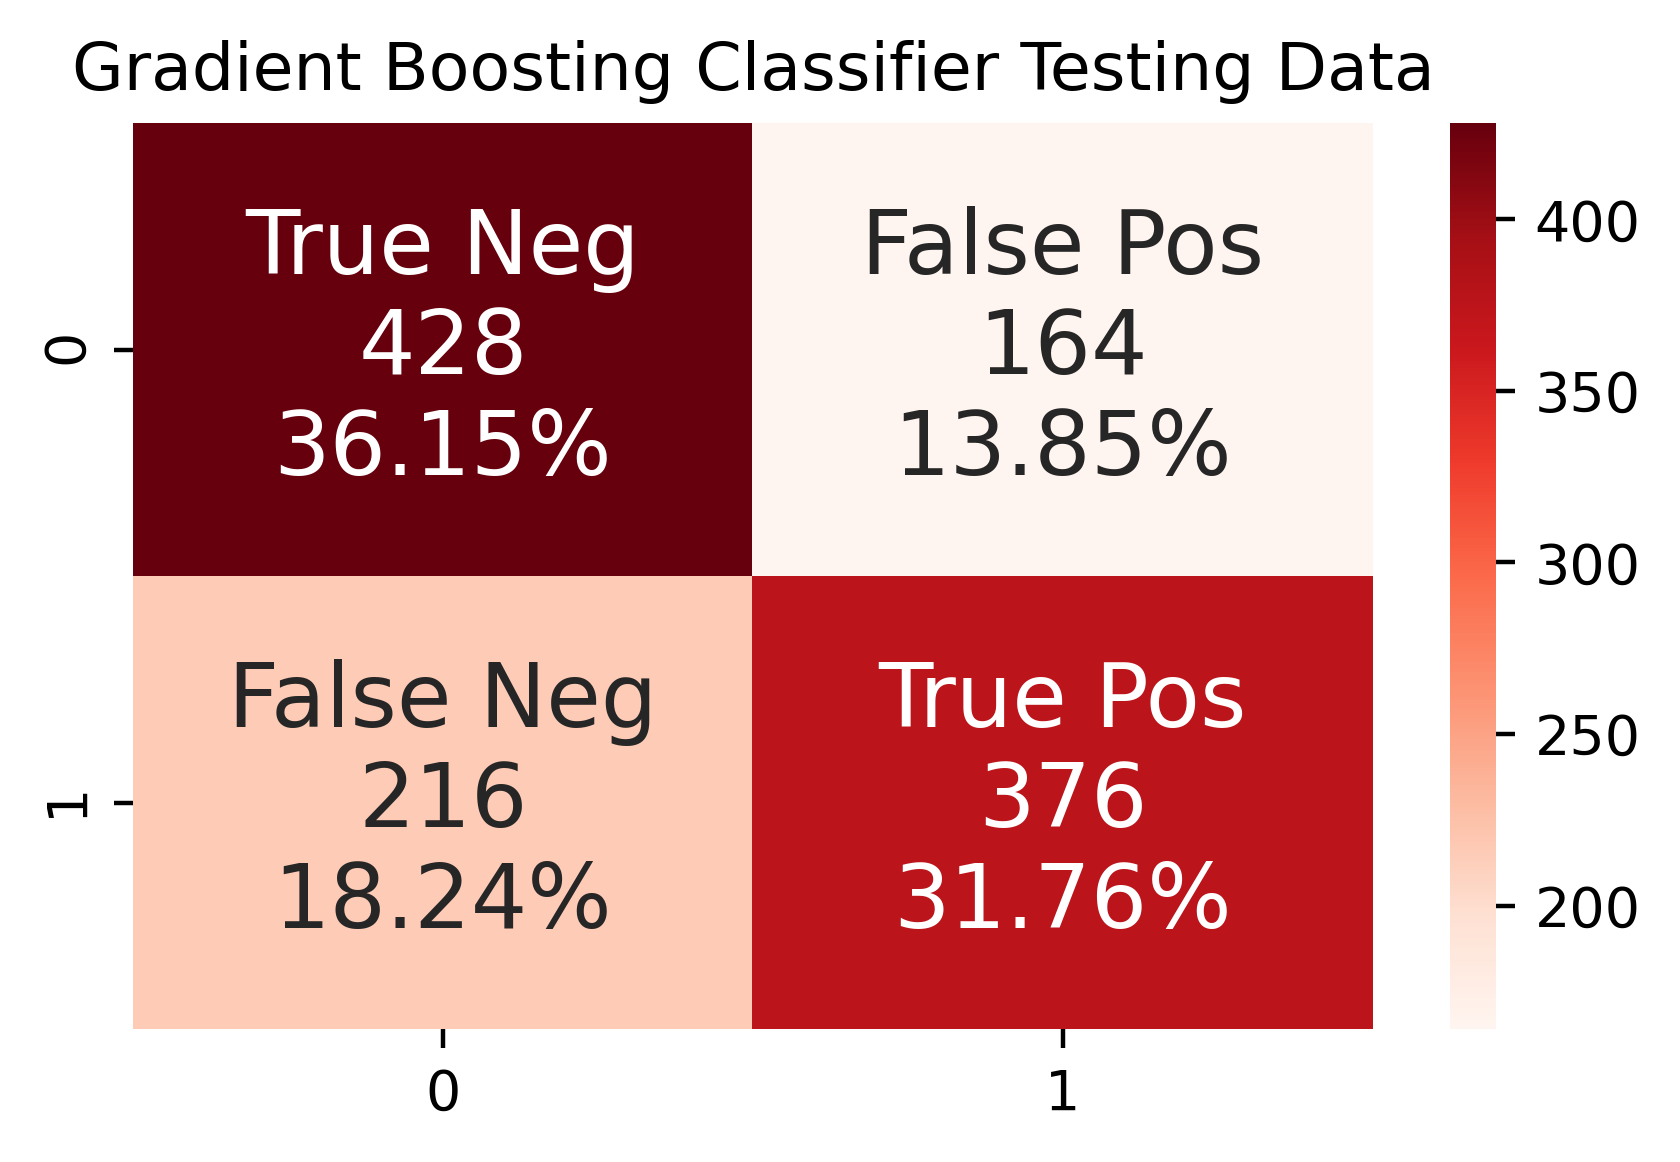

In [12]:
# Confusion matrix plot 
# Test

#Generate predictions with the model using our X values
y_pred = GBC.predict(X_test)

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(5,3),dpi = 400)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Reds', annot_kws={"fontsize":16}, ax=ax)

plt.title('Gradient Boosting Classifier Testing Data')

In [50]:
# Test the final model on the hold out test_set
# assign true & predict vectors to vairables 
y_true, y_pred = y_train, GBC.predict(X_train)

# Build a text report showing the main classification metrics
target_names = ['Non CL Player', 'CL Player']
train_set_results = classification_report(y_true, y_pred, target_names=target_names)

print(train_set_results)

               precision    recall  f1-score   support

Non CL Player       0.71      0.74      0.73      2367
    CL Player       0.73      0.70      0.71      2367

     accuracy                           0.72      4734
    macro avg       0.72      0.72      0.72      4734
 weighted avg       0.72      0.72      0.72      4734



In [51]:
# Test the final model on the hold out test_set
# assign true & predict vectors to vairables 
y_true, y_pred = y_test, GBC.predict(X_test)

# Build a text report showing the main classification metrics
target_names = ['Non CL Player', 'CL Player']
test_set_results = classification_report(y_true, y_pred, target_names=target_names)


print(test_set_results)

               precision    recall  f1-score   support

Non CL Player       0.66      0.72      0.69       592
    CL Player       0.70      0.64      0.66       592

     accuracy                           0.68      1184
    macro avg       0.68      0.68      0.68      1184
 weighted avg       0.68      0.68      0.68      1184



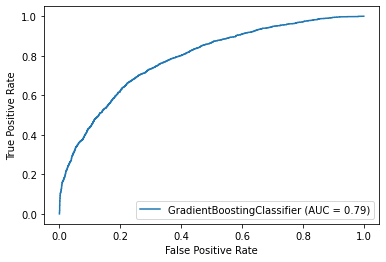

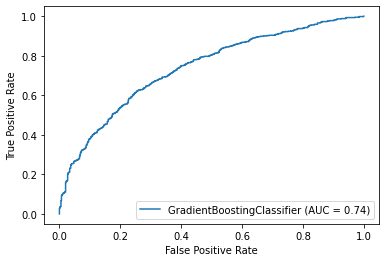

In [52]:
# Roc curves

plot_roc_curve(GBC, X_train, y_train)
plot_roc_curve(GBC, X_test, y_test)

In [16]:
# Cross Validation GBC

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold, KFold

X = X_resampled
y = y_resampled 

clf = GBC
scoring = ['f1','roc_auc','accuracy','balanced_accuracy']

scores =  cross_validate(clf, X, y, cv=StratifiedKFold(5),return_train_score = True,scoring=scoring)
cv = pd.DataFrame(scores)
cv.describe()

,fit_time,score_time,test_f1,train_f1,test_roc_auc,train_roc_auc,test_accuracy,train_accuracy,test_balanced_accuracy,train_balanced_accuracy
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.840249,0.026038,0.650947,0.711160,0.724357,0.788548,0.668805,0.717768,0.668799,0.717767
std,0.024368,0.000787,0.057485,0.011383,0.049248,0.011498,0.043145,0.011008,0.043122,0.011006
min,0.814910,0.024895,0.575729,0.697311,0.663321,0.776089,0.619088,0.705112,0.619088,0.705112
25%,0.827578,0.025817,0.609389,0.701444,0.685599,0.778963,0.627219,0.707497,0.627258,0.707502
50%,0.831768,0.025969,0.674033,0.714501,0.734224,0.787889,0.683277,0.720110,0.683277,0.720110
75%,0.849005,0.026540,0.676445,0.718396,0.756414,0.796469,0.700761,0.727138,0.700692,0.727132
max,0.877985,0.026969,0.719138,0.724145,0.782226,0.803331,0.713682,0.728982,0.713682,0.728982


In [99]:
# Feature importances

df_feature_importance = pd.DataFrame({
    'Features': X_train.columns,
    'Rank Score': GBC.feature_importances_
}).sort_values(by='Rank Score', ascending=False).reset_index(drop=True)

In [100]:
df_feature_importance.sort_values(by='Rank Score', ascending=False)[:20]

,Features,Rank Score
0,Successful Long Balls,0.056552
1,Total Unsuccessful Passes All,0.048475
2,Successful Passes Opposition Half,0.041142
3,Unsuccessful Long Passes,0.037415
4,Unsuccessful Passes Opposition Half,0.035000
5,Total Unsuccessful Passes Excl Crosses Corners,0.034386
6,Successful Passes Defensive third,0.033485
7,GK Long Distribution,0.032909
8,Unsuccessful Passes Final third,0.032497
9,Successful Long Passes,0.032310


In [55]:
# recursive feature selection

# Recrussive feature Extraction GBC

from sklearn.feature_selection import RFECV


# classifications using Logistic regression accuracy scoring
rfecv_GBC = RFECV(estimator=GBC,
                  step=1,
                  cv=StratifiedKFold(5),  # 5-fold CV
                  min_features_to_select = 20,
                  scoring='f1')

# Fit model 
rfecv_GBC.fit(X_resampled, y_resampled)

print("Total number of features : %d" % len(X_resampled.columns))
print("Optimal number of features : %d" % rfecv_GBC.n_features_)

Total number of features : 73
Optimal number of features : 29


In [110]:
# Extraxting the core features with coefficients

df_coef_GBC = pd.DataFrame({
    'Features_GBC': n_feat_GBC,
    'Coef': rfecv_GBC.estimator_.feature_importances_
    }).sort_values(by='Coef', ascending=False).reset_index(drop=True)

df_coef_GBC

,Features_GBC,Coef
0,Unsuccessful Passes Opposition Half,0.070309
1,Successful Long Balls,0.062579
2,Successful Passes Opposition Half,0.053705
3,Total Unsuccessful Passes All,0.045890
4,% successful passes forwards,0.040365
5,Passes Received,0.039460
6,Goals Conceded,0.039033
7,Unsuccessful Long Passes,0.038806
8,Successful Long Passes,0.037403
9,Touches,0.036811


In [107]:
common_features = set(set(df_coef_GBC.Features_GBC).intersection(df_coef_rfc.Features_rfc).intersection(df_coef_logreg.Features_logreg))
common_features

{'% successful passes forwards',
 'Clean Sheets',
 'GK - Pick up',
 'GK Long Distribution',
 'GK Short Distribution',
 'Goals Conceded',
 'Passes Received',
 'Shots On Conceded',
 'Successful Long Balls',
 'Successful Passes Final third',
 'Successful Passes Opposition Half',
 'Total Successful Passes Excl Crosses Corners',
 'Total Unsuccessful Passes Excl Crosses Corners',
 'Touches',
 'Unsuccessful Passes Opposition Half'}

In [129]:
# Merge 73 columns 

relavant_GBC = df_coef_GBC[df_coef_GBC.Features_GBC.isin(['% successful passes forwards',
                                                         'Clean Sheets',
                                                         'GK - Pick up',
                                                         'GK Long Distribution',
                                                         'GK Short Distribution',
                                                         'Goals Conceded',
                                                         'Passes Received',
                                                         'Shots On Conceded',
                                                         'Successful Long Balls',
                                                         'Successful Passes Final third',
                                                         'Successful Passes Opposition Half',
                                                         'Total Successful Passes Excl Crosses Corners',
                                                         'Total Unsuccessful Passes Excl Crosses Corners',
                                                         'Touches',
                                                         'Unsuccessful Passes Opposition Half'])]

relavant_GBC = relavant_GBC.rename({'Features_GBC': 'Features', 'Coef' : 'GBC Variable Imporance'}, axis=1)  # renaming

relavant_rfc = df_coef_rfc[df_coef_rfc.Features_rfc.isin(['% successful passes forwards',
                                                         'Clean Sheets',
                                                         'GK - Pick up',
                                                         'GK Long Distribution',
                                                         'GK Short Distribution',
                                                         'Goals Conceded',
                                                         'Passes Received',
                                                         'Shots On Conceded',
                                                         'Successful Long Balls',
                                                         'Successful Passes Final third',
                                                         'Successful Passes Opposition Half',
                                                         'Total Successful Passes Excl Crosses Corners',
                                                         'Total Unsuccessful Passes Excl Crosses Corners',
                                                         'Touches',
                                                         'Unsuccessful Passes Opposition Half'])]

relavant_rfc = relavant_rfc.rename({'Features_rfc': 'Features', 'Coef' : 'RFC Variable Imporance'}, axis=1)  # renaming

relavant_logreg = df_coef_logreg[df_coef_logreg.Features_logreg.isin(['% successful passes forwards',
                                                         'Clean Sheets',
                                                         'GK - Pick up',
                                                         'GK Long Distribution',
                                                         'GK Short Distribution',
                                                         'Goals Conceded',
                                                         'Passes Received',
                                                         'Shots On Conceded',
                                                         'Successful Long Balls',
                                                         'Successful Passes Final third',
                                                         'Successful Passes Opposition Half',
                                                         'Total Successful Passes Excl Crosses Corners',
                                                         'Total Unsuccessful Passes Excl Crosses Corners',
                                                         'Touches',
                                                         'Unsuccessful Passes Opposition Half'])]

relavant_logreg = relavant_logreg.rename({'Features_logreg': 'Features', 'Coef' : 'LR Coefficients'}, axis=1)  # renaming

In [130]:
result = pd.merge(pd.merge(relavant_logreg , relavant_rfc, on='Features'), relavant_GBC, on='Features')
result


,Features,LR Coefficients,RFC Variable Imporance,GBC Variable Imporance
0,Passes Received,3.386554,0.038909,0.039460
1,% successful passes forwards,1.158227,0.034114,0.040365
2,GK Short Distribution,0.809298,0.024866,0.025526
3,Clean Sheets,0.348835,0.028296,0.021809
4,Unsuccessful Passes Opposition Half,-0.543871,0.049880,0.070309
5,Successful Passes Opposition Half,-0.587853,0.066870,0.053705
6,Goals Conceded,-0.889608,0.043067,0.039033
7,GK Long Distribution,-0.959776,0.033008,0.032739
8,Touches,-0.988180,0.032061,0.036811
9,Total Unsuccessful Passes Excl Crosses Corners,-1.045814,0.045686,0.036145


# F1 Testing

In [46]:
# F test for rfc v logreg f1

from mlxtend.evaluate import combined_ftest_5x2cv


f, p = combined_ftest_5x2cv(estimator1=rfc,
                            estimator2=logreg,
                            X=X_resampled, y=y_resampled,
                            scoring = 'f1',
                            random_seed=1)

print('F statistic: %.3f' % f)
print('p value: %.3f' % p)

F statistic: 8.159
p value: 0.016


In [47]:
# F test for rfc v GBC f1

from mlxtend.evaluate import combined_ftest_5x2cv


f, p = combined_ftest_5x2cv(estimator1=GBC,
                            estimator2=logreg,
                            X=X_resampled, y=y_resampled,
                            scoring = 'f1',
                            random_seed=1)

print('F statistic: %.3f' % f)
print('p value: %.3f' % p)

F statistic: 9.631
p value: 0.011


In [48]:
# F test for rfc v GBC f1

from mlxtend.evaluate import combined_ftest_5x2cv


f, p = combined_ftest_5x2cv(estimator1=rfc,
                            estimator2=GBC,
                            X=X_resampled, y=y_resampled,
                            scoring = 'f1',
                            random_seed=1)

print('F statistic: %.3f' % f)
print('p value: %.3f' % p)

F statistic: 1.149
p value: 0.467


# Accuracy Testing

In [49]:
# F test for rfc v logreg accuracy

f, p = combined_ftest_5x2cv(estimator1=rfc,
                            estimator2=logreg,
                            X=X_resampled, y=y_resampled,
                            scoring = 'accuracy',
                            random_seed=1)

print('rfc vs logreg')
print('F statistic: %.3f' % f)
print('p value: %.3f' % p)

# F test for rfc v GBC accuracy

from mlxtend.evaluate import combined_ftest_5x2cv


f, p = combined_ftest_5x2cv(estimator1=GBC,
                            estimator2=logreg,
                            X=X_resampled, y=y_resampled,
                            scoring = 'accuracy',
                            random_seed=1)

print('GBC vs logreg')
print('F statistic: %.3f' % f)
print('p value: %.3f' % p)

# F test for rfc v GBC accuracy

from mlxtend.evaluate import combined_ftest_5x2cv


f, p = combined_ftest_5x2cv(estimator1=rfc,
                            estimator2=GBC,
                            X=X_resampled, y=y_resampled,
                            scoring = 'accuracy',
                            random_seed=1)
print('GBC vs rfc')
print('F statistic: %.3f' % f)
print('p value: %.3f' % p)

rfc vs logreg
F statistic: 5.159
p value: 0.042
GBC vs logreg
F statistic: 5.723
p value: 0.034
GBC vs rfc
F statistic: 1.503
p value: 0.342


## ROC_AUC

In [50]:
# F test for rfc v logreg accuracy

f, p = combined_ftest_5x2cv(estimator1=rfc,
                            estimator2=logreg,
                            X=X_resampled, y=y_resampled,
                            scoring = 'roc_auc',
                            random_seed=1)

print('rfc vs logreg')
print('F statistic: %.3f' % f)
print('p value: %.3f' % p)

# F test for rfc v GBC accuracy

from mlxtend.evaluate import combined_ftest_5x2cv


f, p = combined_ftest_5x2cv(estimator1=GBC,
                            estimator2=logreg,
                            X=X_resampled, y=y_resampled,
                            scoring = 'roc_auc',
                            random_seed=1)

print('GBC vs logreg')
print('F statistic: %.3f' % f)
print('p value: %.3f' % p)

# F test for rfc v GBC accuracy

from mlxtend.evaluate import combined_ftest_5x2cv


f, p = combined_ftest_5x2cv(estimator1=rfc,
                            estimator2=GBC,
                            X=X_resampled, y=y_resampled,
                            scoring = 'roc_auc',
                            random_seed=1)
print('GBC vs rfc')
print('F statistic: %.3f' % f)
print('p value: %.3f' % p)

rfc vs logreg
F statistic: 3.713
p value: 0.080
GBC vs logreg
F statistic: 5.906
p value: 0.032
GBC vs rfc
F statistic: 0.877
p value: 0.600
